In [10]:
import gluoncv as gcv
import mxnet as mx
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
image_url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/mt_baker.jpeg'
image_filepath = 'mt_baker.jpg'
im_fname=gcv.utils.download(url=image_url,path=image_filepath)

In [13]:
#  this loads the image is a multi dimensional array called an ND array. MXNet ND array is very similar to NumPy ND arrays.
image = mx.image.imread(im_fname)

In [14]:
print('type', type(image))

type <class 'mxnet.ndarray.ndarray.NDArray'>


In [16]:
print('shape', image.shape)
# This in HWC layout as Height, Weight, Channel

shape (1458, 3000, 3)


In [17]:
# After loading an image with imread, all values will be unsigned 8-bit integers.
print('data type: ', image.dtype)

data type:  <class 'numpy.uint8'>


## Visualize the image
> We can visualize the image using pyplot.
But we first need to convert the image from an MXNet ND array to a NumPy ND array with as NumPy. 

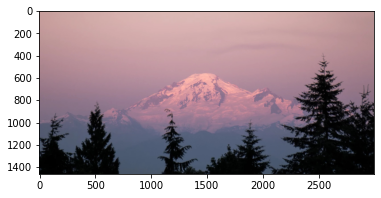

In [18]:
plt.imshow(img.asnumpy())
plt.show()

## Predict the image classification
* The network expects an input with four dimensions. It expects NCHW instead of HWC. N for the batch dimension, C for channel, H for height, and W for width.
* The neural network will expect 32-bit floats. And instead of values ranging from 0 to 255, our value should have an average value of 0 and a standard deviation of 1.
* GluonCV has a transform function to do all of this in a single step. Since we'll be using a neural network that was pre-trained on imagenet, we'll use the imagenet.transform_eval function. Other data sets have different transform functions.

### Prepare the data

In [ ]:
image = gcv.data.transforms.presets.imagenet.transform_eval(image)

In [20]:
# Our data layout is now NCHW. We have 32-bit floats, and the range of values looks centered around 0.
print('shape', image.shape)
print('data type: ', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape (1, 3, 224, 224)
data type:  <class 'numpy.float32'>
minimum value: -2.117904
maximum value: 2.2489083


> Transforming eval takes a square crop from the center of the image and re-scales this to 224 pixels.
> Why is this done?
> It was a convention used when pre-training the network. So it's important that we apply exactly the same steps when using the network for predictions. 224 pixels also makes the image much more manageable in terms of the amount of network memory and computation required.

### Load the Model

we will use a resonant 50D network that has been pre-trained on imagenet.

In [23]:
network = gcv.model_zoo.get_model('ResNet50_v1d', pretrained=True)

# Alternatively you can use the function that corresponds to the same model.
# network = gcv.model_zoo.resnet50_v1d(pretrained=True)

55464KB [00:23, 2358.09KB/s]                           


### Make Predictions

In [24]:
prediction = network(image)

In [25]:
print(prediction.shape)

(1, 1000)


Prediction has shape of 1 by 1,000. Our input was a batch of images, and our output is a batch of predictions. We only had one input image. So let's just remove the extra dimension from prediction. 

In [26]:
prediction = prediction[0]
print(prediction.shape)

(1000,)


Our prediction is now an array with 1000 values. We used the model that has been pre-trained on imagenet 1K, so we have a prediction for each of the 1000 classes from that data set.

When we look at a sample of the predictions, though, it's not entirely clear how we should interpret these values. Some values are negative and others are much higher than one.

In [27]:
print(prediction[950:])


[ 1.602439    0.33270508  0.8699611   0.32028967  0.53283924 -0.29865998
  0.34427112  0.63213533  1.3812519   0.24068044  1.024216    0.85197353
  0.14053807  0.05959851  0.23962055  0.23323406  0.5778731   0.27351195
  0.7030184   0.31220537  6.5562615   1.386783    1.8386288  -0.15775806
  1.6904416   4.2608128   2.1198077   1.1774894   2.255857    4.4849067
  9.488942   -0.31659335 -0.63358176 -0.53062105  0.8886497   0.74600947
  0.6333253   0.07998586  0.4988404   0.48063403  0.67252725  0.48652083
  0.46989438  1.0499997   1.2532173   0.89665234 -0.46537554  0.64390945
  0.7080569   0.7872208 ]
<NDArray 50 @cpu(0)>


We're looking at the raw outputs of the network, which is sometimes referred to as logits. We can convert the logits to probabilities using the softmax function.

In [30]:
probability = mx.nd.softmax(prediction)

In [32]:
rounded_probability = mx.nd.round(probability)
print(rounded_probability[950:])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
<NDArray 50 @cpu(0)>


Since we have a large number of classes, let's use the top K function to extract the top five most likely classes. 

In [35]:
# Get top-k
k = 5
topk_indices = mx.nd.topk(probability, k=k)
topk_indices


[980. 970. 979. 672. 975.]
<NDArray 5 @cpu(0)>

We now have a sorted list of class indices.

Class 980 is the most likely class for our mount baker image. We could have applied the top k function to the logits too and got the same answer, because the softmax function doesn't change the ranking of the classes.

We need to convert these class indices into human readable labels. Our network has a list of the classes that were used for pre-training. We can use this to look up the class labels. Class index 567 corresponds to frying pan, for example. 

In [36]:
network.classes[567]

'frying pan'

We're now ready to generate our final predictions. We can loop through the top five most probable classes and extract the human readable labels and associated probabilities.

We need to convert our class index from an MXNet float to a Python integer faster. As scalar is used to convert an MXNet ND array
with one element to a Python literal.

In [39]:
for i in range(k):
    class_index = topk_indices[i].astype('int').asscalar()
    class_label = network.classes[class_index]
    class_probability = probability[class_index]
    print(f'{i+1} {class_label} {class_probability.asscalar()*100:0.3}%')

1 volcano 84.1%
2 alp 4.48%
3 valley 0.564%
4 mountain tent 0.524%
5 lakeside 0.451%
